In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c hms-harmful-brain-activity-classification

100% 18.4G/18.4G [18:24<00:00, 21.3MB/s]
100% 18.4G/18.4G [18:24<00:00, 17.9MB/s]


In [5]:
!ls

drive  hms-harmful-brain-activity-classification.zip  kaggle.json  sample_data


In [ ]:
!unzip /content/hms-harmful-brain-activity-classification.zip

google drive mount

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import gc
from sklearn.model_selection import KFold
import torch.nn.init as init
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from urllib.request import urlopen
import matplotlib.pyplot as plt

In [9]:
import random

seed = 40
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
warnings.filterwarnings('ignore')

data load

In [12]:
df_train = pd.read_csv('/content/train.csv')

In [13]:
offset = df_train['spectrogram_label_offset_seconds']

In [14]:
df_train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [15]:
target = df_train.columns[-6:]
data = df_train.columns[:-6]
x = df_train[data]

y = df_train[target].values
sum_y = y.sum(axis = 1 ,keepdims=True)
y = y / sum_y
target = y

# x는 pd 형식의 훈련데이터, y는 value만 뽑아냄

In [16]:
eeg_dir = "/content/train_eegs"
spectrogram_dir = "/content/train_spectrograms"

eeg_id - spectrogram_id - eeg,spectrogram_path

preprocessing

In [17]:
train_x = x.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first'})
train_x.columns = ['spec_id']

tmp = x.groupby('eeg_id')[['patient_id']].agg('first') # The code adds the patient_id for each eeg_id to the train DataFrame. This links each EEG segment to a specific patient.
train_x['patient_id'] = tmp

target_column = ['seizure_vote' ,'lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']
tmp = df_train.groupby('eeg_id')[target_column].agg('sum')
for t in target_column:
    train_x[t] = tmp[t].values

y = train_x[target_column].values
y = y / y.sum(axis = 1, keepdims = True)
train_x[target_column] = y

tmp = x.groupby('eeg_id')[['expert_consensus']].agg('first')
train_x['target'] = tmp

train_x = train_x.reset_index()

In [18]:
train_x['eeg_path'] = train_x['eeg_id'].apply(lambda x: os.path.join(eeg_dir, f'{x}.parquet'))
train_x['spectrogram_path'] = train_x['spec_id'].apply(lambda x: os.path.join(spectrogram_dir, f'{x}.parquet'))

In [19]:
train_x['patient_id'] = (train_x['patient_id'] - train_x['patient_id'].min()) / (train_x['patient_id'].max() - train_x['patient_id'].min())
train_x['eeg_id'] = (train_x['eeg_id'] - train_x['eeg_id'].min()) / (train_x['eeg_id'].max() - train_x['eeg_id'].min())
train_x['spec_id'] = (train_x['spec_id'] - train_x['spec_id'].min()) / (train_x['spec_id'].max() - train_x['spec_id'].min())

x = train_x
x = x.fillna(0)

In [20]:
x['Seizure'] = 0
x['GPD'] = 0
x['LPD'] = 0
x['LPDA'] = 0
x['GPDA'] = 0
x['Other'] = 0

x.loc[x['target'] == 'Seizure', 'Seizure'] = 1
x.loc[x['target'] == 'GPD', 'GPD'] = 2
x.loc[x['target'] == 'LPD' , 'LPD'] = 3
x.loc[x['target'] == 'LPDA' , 'LPDA'] = 4
x.loc[x['target'] == 'GPDA' , 'GPDA'] = 5
x.loc[x['target'] == 'Other' , 'Other'] = 6

x['answer'] = x['target']

x['target'] = x['Seizure'] + x['GPD'] + x['LPD'] + x['LPDA'] + x['GPDA'] + x['Other']

x.drop(['Seizure' , 'GPD' , 'LPD' , 'LPDA' , 'GPDA' , 'Other'] , axis = 1 , inplace = True)

data loader func

In [21]:
def load_spectrogram_data(spec_path):
    if os.path.isfile(spec_path):
        spec_data = pd.read_parquet(spec_path)
        return spec_data
    else:
        print(f"Invalid file path: {spec_path}")
        return None

In [22]:
class data_loader(Dataset):
    def __init__(self,imgs, targets):
        self.imgs=imgs
        self.targets=targets
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self , idx):
        image_path=self.imgs[idx]
        target_path=self.targets[idx]

        return image_path , target_path

In [23]:
class Spec():
    def __init__(self, start , batch):
      self.start = start
      self.batch = batch

    def spec_input(self , for_train):
      if for_train == 1:
        img = []
        target = []
        columns = ['seizure_vote' , 'lpd_vote' , 'gpd_vote' , 'lrda_vote' , 'grda_vote', 'other_vote']

        for i in range(self.start , self.start + self.batch):
          idx = i - self.start
          img.append(0)
          img[idx] = load_spectrogram_data(x['spectrogram_path'][i])
          target.append(0)
          target[idx] = x.loc[i][columns]

          target[idx] = target[idx].values
          target[idx] = np.array(target[idx])
          target[idx] = target[idx].tolist()
          target[idx] = np.array(target[idx])

          # spec data 만들기
          sp_offset = int(offset[i])
          sp = img[idx].loc[(img[idx].time>=sp_offset)&(img[idx].time<sp_offset+600)]
          img[idx] = sp

          img[idx] = img[idx].iloc[: , 1:401]

          img[idx] = img[idx].fillna(0)
          img[idx] = img[idx].values
          img[idx] = np.array(img[idx])
      else:
        img = []
        target = 0
        columns = ['seizure_vote' , 'lpd_vote' , 'gpd_vote' , 'lrda_vote' , 'grda_vote', 'other_vote']

        for i in range(self.start , self.start + self.batch):
            idx = i - self.start
            img.append(0)
            img[idx] = load_spectrogram_data(df_test['spec_path'][i])
            img[idx] = img[idx].iloc[: , 1:401]

            img[idx] = img[idx].fillna(0)
            img[idx] = img[idx].values
            img[idx] = np.array(img[idx])

      return img , target

In [24]:
spec = Spec(0 , x.shape[0])
image , label_y = spec.spec_input(1)

image visualization

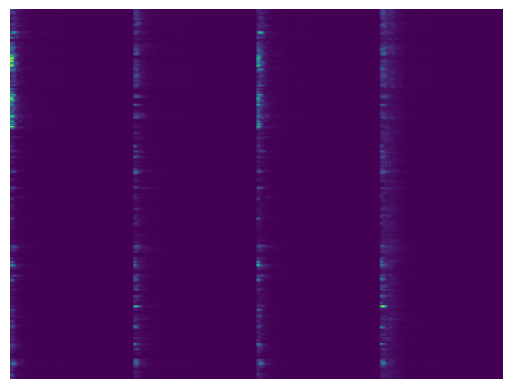

In [25]:
# NumPy 배열을 이미지로 시각화
plt.imshow(image[1])
plt.axis('off')  # 축 제거
plt.show()

data preprocessing - (2)

In [26]:
def making_dataset(image , label_y , for_train):
  if for_train == 1:
    target= 0
    target = torch.tensor(label_y)
    target = np.array(target)
    for i in range(len(target)):
      target[i] = np.array(target[i])
    target = target.tolist()

    result = []
    for i in range(len(image)):
      result.append(0)
      im = torch.tensor(image[i])
      result[i] = torch.log(im + 0.0000000000000001)
      result[i] = np.array(result[i])

    for j in range(len(image)):
      i = len(image) - j
      if len(result) >= i+1:
        if len(target) >= i+1:
          if result[i].shape[0] < 1:
            del result[i]
            del target[i]

    transform = transforms.Compose([
      transforms.Resize((672,224)),
      #transforms.RandomHorizontalFlip(p=0.3),
      #transforms.RandomVerticalFlip(p=0.3),
    ])

    for i in range(len(result)):
      result[i] = torch.tensor(result[i])
      result[i] = result[i].unsqueeze(0)
      result[i] = torch.tensor(result[i])
      target[i] = torch.tensor(target[i])

    for i in range(len(result)):
      result[i] = transform(result[i])
      if result[i].max() != result[i].min():
        result[i] = (result[i]-result[i].max())/(result[i].max() - result[i].min())
      else:
        result[i] = torch.zeros(672,224)

      result[i] = result[i].reshape(3,224,224)

  else:
    result = []
    target= 0
    for i in range(len(image)):
      result.append(0)
      im = torch.tensor(image[i])
      result[i] = torch.log(im + 0.0000000000000001)
      result[i] = np.array(result[i])

    for j in range(len(image)):
      i = len(image) - j
      if len(result) >= i+1:
        if result[i].shape[0] < 1:
          del result[i]

    transform = transforms.Compose([
      transforms.Resize((672,224)),
    ])

    for i in range(len(result)):
      result[i] = torch.tensor(result[i])
      result[i] = result[i].unsqueeze(0)
      result[i] = torch.tensor(result[i])

    for i in range(len(result)):
      result[i] = transform(result[i])
      if result[i].max() != result[i].min():
        result[i] = (result[i]-result[i].max())/(result[i].max() - result[i].min())
      else:
        result[i] = torch.zeros(672,224)
      result[i] = result[i].reshape(3,224,224)


  return result , target # result.shape : (3,224,224)

In [27]:
data,target=making_dataset(image,label_y,1)

image visualization after log transformation

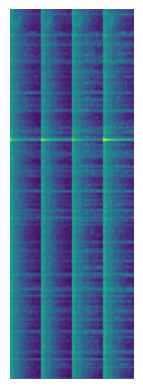

In [28]:
# NumPy 배열을 이미지로 시각화
plt.imshow(data[0].view(672,224))
plt.axis('off')  # 축 제거
plt.show()

In [29]:
print(len(data) , len(target))

15122 15122


Data loader

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

train_dataset = data_loader(X_train, y_train)
test_dataset = data_loader(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= int(len(X_test)*0.2), shuffle=True)

transfer learning or fine tuning

finetuning

In [ ]:
!pip install timm
import timm

In [32]:
vit_models = [model_name for model_name in timm.list_models(pretrained=True) if 'efficientnet' in model_name]
print(vit_models)

['efficientnet_b0.ra4_e3600_r224_in1k', 'efficientnet_b0.ra_in1k', 'efficientnet_b1.ft_in1k', 'efficientnet_b1.ra4_e3600_r240_in1k', 'efficientnet_b1_pruned.in1k', 'efficientnet_b2.ra_in1k', 'efficientnet_b2_pruned.in1k', 'efficientnet_b3.ra2_in1k', 'efficientnet_b3_pruned.in1k', 'efficientnet_b4.ra2_in1k', 'efficientnet_b5.sw_in12k', 'efficientnet_b5.sw_in12k_ft_in1k', 'efficientnet_el.ra_in1k', 'efficientnet_el_pruned.in1k', 'efficientnet_em.ra2_in1k', 'efficientnet_es.ra_in1k', 'efficientnet_es_pruned.in1k', 'efficientnet_lite0.ra_in1k', 'efficientnetv2_rw_m.agc_in1k', 'efficientnetv2_rw_s.ra2_in1k', 'efficientnetv2_rw_t.ra2_in1k', 'gc_efficientnetv2_rw_t.agc_in1k', 'test_efficientnet.r160_in1k', 'tf_efficientnet_b0.aa_in1k', 'tf_efficientnet_b0.ap_in1k', 'tf_efficientnet_b0.in1k', 'tf_efficientnet_b0.ns_jft_in1k', 'tf_efficientnet_b1.aa_in1k', 'tf_efficientnet_b1.ap_in1k', 'tf_efficientnet_b1.in1k', 'tf_efficientnet_b1.ns_jft_in1k', 'tf_efficientnet_b2.aa_in1k', 'tf_efficientnet_b2

In [57]:
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=True)

In [47]:
input_size = model.default_cfg['input_size']
print(f"Model Input Size: {input_size}")

Model Input Size: (3, 224, 224)


In [58]:
input = 1280
for param in model.parameters():
  param_requires_grad = True
del model.classifier
model.classifier = nn.Sequential(
    nn.Linear(input, 6),
    nn.Softmax(dim=1)
)
#for param in model.head.classifier.parameters():
#  param_requires_grad = True

In [59]:
model = model.to(device)

model 내부

In [ ]:
model

Loss function define

In [60]:
kl_loss = nn.KLDivLoss(reduction= 'batchmean')
softmax_loss = nn.Softmax()

In [61]:
# 1. `fc` 레이어의 파라미터를 미리 가져오기
fc_params = list(model.classifier.parameters())

# 2. 전체 모델의 파라미터 중 `fc`를 제외한 나머지 파라미터 선택
remain_params = [p for p in model.parameters() if p not in set(fc_params)]
remain_params_list = list(remain_params)

In [62]:
# 3. 파라미터 그룹화: 전체 파라미터와 새로 추가된 파라미터에 다른 학습률 적용
optimizer = torch.optim.Adam([
    {'params': fc_params, 'lr': 0.005},  # 새 레이어는 높은 학습률
    {'params': remain_params_list, 'lr': 1e-6}      # 기존 파라미터는 낮은 학습률
])

scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0005)

In [63]:
target_loss = 0.8  # 손실 기준 (이 값 이하가 되면 학습 중단)
checkpoint_path = "/content/drive/MyDrive/model_weight.pth"  # 체크포인트 경로

In [64]:
cnt = 0
loss_history = []
test_loss_history = []
softmax = nn.Softmax(dim=1)
mse_loss = nn.MSELoss()
for epoch in range(400000):
  model.train()
  for images, labels in train_loader:
    images = torch.tensor(images)
    images = images.to(torch.float32)
    labels = torch.tensor(labels)
    labels = labels.to(torch.float32)

    images = images.to(device)
    labels = labels.to(device)

    #print(images.shape)

    output = model(images)
    log_probs = torch.log(output + 0.0000000000000001)

    loss = kl_loss(log_probs, labels[:,:6])

    # loss history append
    loss_history.append(loss.item())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

  model.eval()
  with torch.no_grad():
    for input, test_label in  test_loader:
      input = torch.tensor(input)
      input = input.to(torch.float32)
      test_label = torch.tensor(test_label)
      test_label = test_label.to(torch.float32)

      input = input.to(device)
      test_label = test_label.to(device)

      test_output = model(input)
      test_log_prob = torch.log(test_output + 0.0000000000000001)

      test_loss = kl_loss(test_log_prob, test_label[:,:6])

      test_loss = test_loss.item()
      test_loss_history.append(test_loss)

    # 손실 기준을 만족하면 체크포인트 저장 및 학습 중단
      if test_loss <= target_loss:
        print(f"Target loss {target_loss} reached at epoch {epoch+1}. Saving checkpoint...")
        torch.save(model.state_dict(), checkpoint_path)
        break  # 학습 중단

        print("Training finished.")

    print("epoch : {} , loss : {} , test_loss : {} , optimizer : {}".format(epoch, loss , test_loss ,  optimizer.param_groups[0]['lr']))

Target loss 0.8 reached at epoch 1. Saving checkpoint...
epoch : 0 , loss : 1.0813345909118652 , test_loss : 0.7647281885147095 , optimizer : 0.004290230988339619
Target loss 0.8 reached at epoch 2. Saving checkpoint...
epoch : 1 , loss : 1.1937121152877808 , test_loss : 0.6811025142669678 , optimizer : 0.0026087213310586077
Target loss 0.8 reached at epoch 3. Saving checkpoint...
epoch : 2 , loss : 0.5337737202644348 , test_loss : 0.7065491080284119 , optimizer : 0.0010163452037546062
Target loss 0.8 reached at epoch 4. Saving checkpoint...
epoch : 3 , loss : 0.7284358739852905 , test_loss : 0.7295732498168945 , optimizer : 0.0005177419220424294
Target loss 0.8 reached at epoch 5. Saving checkpoint...
epoch : 4 , loss : 0.6537694334983826 , test_loss : 0.7022789716720581 , optimizer : 0.0014274831823417264
Target loss 0.8 reached at epoch 6. Saving checkpoint...
epoch : 5 , loss : 0.3849574625492096 , test_loss : 0.68454509973526 , optimizer : 0.003171607957819734
Target loss 0.8 reac

KeyboardInterrupt: 

ram 비우기

In [65]:
# 모델과 옵티마이저 삭제
del model  # 모델 객체 삭제
del optimizer  # 옵티마이저 객체 삭제 (필요 시)
del scheduler

# 가비지 컬렉터(gc)를 사용해 참조되지 않은 객체 정리
gc.collect()  # CPU 메모리 해제

# GPU 메모리 해제 (필요한 경우)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()  # 추가적인 GPU 메모리 정리

추론

In [ ]:
test_spec_dir = '/content/test_spectrograms'
df_test = pd.read_csv('/content/test.csv')
df_test['spec_path'] = df_test['spectrogram_id'].apply(lambda x: os.path.join(test_spec_dir, f'{x}.parquet'))

In [ ]:
pred = model.eval()
pred = pred.to(device)

dfl = df_test['spec_path'].shape[0]
np_test_preds = np.zeros((dfl , 6))

In [ ]:
fake_label = [0,0,0,0,0,0]
fake_label = np.array(fake_label)
for i in range(dfl):
    test_spec_fun = Spec(i , 1)
    test_spec , _ = test_spec_fun.spec_input(0)
    test_spec = test_spec[0]
    test_spec = torch.tensor(test_spec)
    if test_spec.shape[0] > 0:
        test_spec = torch.tensor(test_spec)
        test_spec = test_spec.to(torch.float32)
        test_spec = [test_spec]
        test_spec , _ = making_dataset(test_spec ,fake_label, 0)
        test_spec = np.array(test_spec[0])
        test_spec = torch.tensor(test_spec)
        test_spec=test_spec.to(device)
        test_spec = test_spec.unsqueeze(0)
        p = pred(test_spec)
        pre = p.tolist()
        for j in range(0,6):
            np_test_preds[i][j] = pre[0][j]

In [ ]:
np_test_preds

In [ ]:
differ = sum(np_test_preds[0]) - 1
new_max_value = max(np_test_preds[0]) - differ
for i in range(6):
  if np_test_preds[0][i] == max(np_test_preds[0]):
    np_test_preds[0][i] = new_max_value

In [ ]:
sum(np_test_preds[0])

Model 저장

In [ ]:
# 모델 저장 경로
model_path = "/content/drive/MyDrive/model_weight.pth"

# 모델의 가중치(state_dict) 저장
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")